# The Recipe for a Successful Movie
**TheBlockbusters**: Stefano Ferioli, Francesco Bellotto, Luca Pisoni, Mouhamad Rawas, Hugo Lagergren

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.stats.weightstats
import importlib
import sys
import scipy.stats
from scipy import stats
import os
import warnings
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML
import statsmodels.formula.api as smf

sys.path.append(os.path.abspath(os.path.join('src', 'utils')))

import exploratory_analysis
import plotting
import data_cleaning
import data_utils
importlib.reload(exploratory_analysis)
importlib.reload(plotting)
importlib.reload(data_cleaning)
importlib.reload(data_utils)
from exploratory_analysis import *
from plotting import *
from data_cleaning import *
from data_utils import *
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import statsmodels.formula.api as smf
import networkx as nx
import graphviz
from sklearn.tree import export_graphviz
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

# The original dataset

First, we will briefly look at the original datasets, and see what can be done to improve their quality.

In [2]:
DATA_FOLDER = "data"

MOVIES_DATASET = DATA_FOLDER+"\movie.metadata.tsv" 
CHARACTERS_DATASET = DATA_FOLDER+"\character.metadata.tsv"

# Dataset loading
movies = pd.read_csv(MOVIES_DATASET, sep='\t', header=None)
characters = pd.read_csv(CHARACTERS_DATASET, sep='\t', header=None)

We look for missing values.

In [3]:
mapper = {0: 'wikipedia_id',
          1: 'f_id',
          2: 'title',
          3: 'rel_date',
          4: 'revenue',
          5: 'runtime',
          6: 'language',
          7: 'country',
          8: 'genre'
          }

movies = movies.rename(columns=mapper, errors="raise")

print_missing_stats(movies)

Total length: 81741
Ratio of missing wikipedia_id: 0.00
Ratio of missing f_id: 0.00
Ratio of missing title: 0.00
Ratio of missing rel_date: 0.08
Ratio of missing revenue: 0.90
Ratio of missing runtime: 0.25
Ratio of missing language: 0.00
Ratio of missing country: 0.00
Ratio of missing genre: 0.00


Notice that much information that we could use to carry out our analysis are not present. For example, we are interested in ratings, number of votes, budgets, revenues, production companies, and so on.

In [4]:
mapper = {
    0: "wiki_movie_ID",
    1: "freebase_movie_ID",
    2: "rel_date",
    3: "char_name",
    4: "actor_birth",
    5: "actor_gender",
    6: "actor_height",
    7: "actor_ethnicity_ID",
    8: "actor_name",
    9: "actor_age_rel",
    10: "character_actor_map_ID",
    11: "character_ID",
    12: "actor_ID"
}

characters = characters.rename(mapper=mapper, axis=1)

print_missing_stats(characters)

Total length: 450669
Ratio of missing wiki_movie_ID: 0.00
Ratio of missing freebase_movie_ID: 0.00
Ratio of missing rel_date: 0.02
Ratio of missing char_name: 0.57
Ratio of missing actor_birth: 0.24
Ratio of missing actor_gender: 0.10
Ratio of missing actor_height: 0.66
Ratio of missing actor_ethnicity_ID: 0.76
Ratio of missing actor_name: 0.00
Ratio of missing actor_age_rel: 0.35
Ratio of missing character_actor_map_ID: 0.00
Ratio of missing character_ID: 0.57
Ratio of missing actor_ID: 0.00


A lot of relevant information is missing (e.g. actors' places of birth or data about directors).

In order to overcome these issues, we incorporated data from three additional sources: The Movie Database (TMDB), Internet Movie Database (IMDB) and Wikidata. For the first one, we downloaded the data from [Kaggle](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies). For IMDB, we utilized the [IMDB Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/). Lastly, for Wikidata, we wrote a script that utilizes the [Wikidata Query Service](https://query.wikidata.org/) to automatically retrieve extensive information about movies, casts, and related people. The code utilized is contained in the notebook `src/scripts/scrape_wikidata.ipynb`.

We have integrated the MovieSummaries dataset with these additional sources into a unified dataset. The complete integration code is available in the `src/scripts` folder of the repository.

From now on, we will just use the datasets generated at the end of this process.

# Basic dataset exploration

We start by importing the cleaned datasets.
- `movies_complete` contains all the information about movies.
- `people_complete` contains all the information about actors and directors in the film industry
- `movie_actor_complete` relate the first two datasets, containing information about the cast and the director(s) of each movie
- `wikidata_people_country` contains the information about the country of birth of many actors and directors.

In addition we have that
- `movies_complete` and `movie_actor_complete` can be merged on `freebase_id_movie`
- `movie_actor_complete` and `people_complete` can be merged on `univocal_id_actor`
- `people_complete` and `wikidata_people_country` can be merged on `wikidata_id_actor`

In [5]:
DATA_FOLDER = "data"
PLOTS_FOLDER = "plots/"

MOVIES_DATASET = DATA_FOLDER + "\movies_complete.tsv" 
PEOPLE_DATASET = DATA_FOLDER + "\people_complete.tsv"
MOVIE_ACTOR_DATASET = DATA_FOLDER + "\movie_actor_complete.tsv"
COUNTRIES_DATASET = DATA_FOLDER + "\wikidata_people_country.csv"

# Datasets loading
movies_complete = pd.read_csv(MOVIES_DATASET, sep='\t', header=0, low_memory=False)
people_complete = pd.read_csv(PEOPLE_DATASET, sep='\t', header=0)
movie_actor_complete = pd.read_csv(MOVIE_ACTOR_DATASET, sep='\t', header=0, low_memory=False)
wikidata_people_country = pd.read_csv(COUNTRIES_DATASET, header=0)

We look for missing values in the movies dataset.

In [6]:
print_missing_stats(movies_complete)

Total length: 79764
Ratio of missing freebase_id_movie: 0.00
Ratio of missing wikidata_id_movie: 0.04
Ratio of missing wikipedia_id_movie: 0.00
Ratio of missing imdb_id_movie: 0.18
Ratio of missing tmdb_id_movie: 0.21
Ratio of missing wikipediaLink: 0.06
Ratio of missing primaryTitle: 0.00
Ratio of missing originalTitle: 0.18
Ratio of missing description_wikidata: 0.04
Ratio of missing release_date: 0.11
Ratio of missing release_year: 0.00
Ratio of missing runtimeMinutes: 0.07
Ratio of missing original_language: 0.21
Ratio of missing languages: 0.03
Ratio of missing countries: 0.01
Ratio of missing genres_original: 0.03
Ratio of missing genres_wikidata: 0.15
Ratio of missing genres_IMDB_TMDB: 0.19
Ratio of missing rating_imdb: 0.23
Ratio of missing numVotes_imdb: 0.23
Ratio of missing budget: 0.88
Ratio of missing revenue: 0.89
Ratio of missing production_companies: 0.32
Ratio of missing overview_tmdb: 0.24
Ratio of missing keywords_tmdb: 0.52


Apart from revenues and budget, there are no features with a very large number of missing values. We will try to deal with this later, once we have fully explored our dataset. 

In order to better understand the possible correlations between different features, we plot a scatter matrix with the numerical covariates.

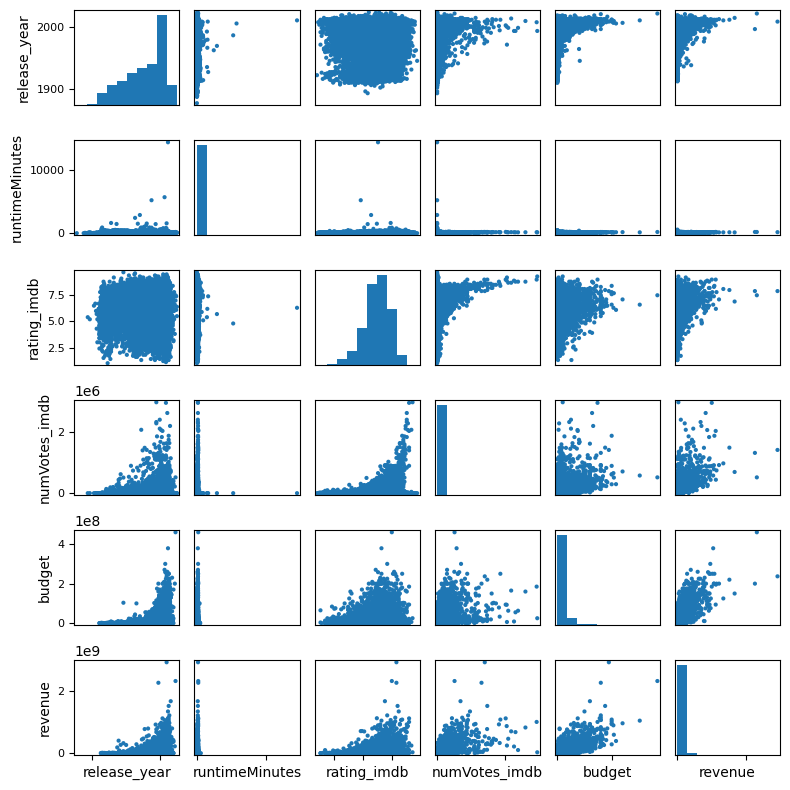

In [7]:
# Features to plot
to_keep = ['release_year', 'runtimeMinutes', 'rating_imdb', 'numVotes_imdb', 'budget', 'revenue']
figsize = (8,8)

movies_complete['runtimeMinutes'] = pd.to_numeric(movies_complete['runtimeMinutes'], errors='coerce')
plot_scatter_matrix(movies_complete, to_keep, by='include', figsize=figsize)

From the matrix, we notice that some possible correlations exist between the considered variables. We will explore this deeper in further analysis.

We continue analysing the missing values in `people_complete`.

In [8]:
print_missing_stats(people_complete)

Total length: 194234
Ratio of missing univocal_id_actor: 0.00
Ratio of missing freebase_id_actor: 0.13
Ratio of missing wikidata_id_actor: 0.43
Ratio of missing imdb_id_actor: 0.45
Ratio of missing wikipediaLink_actor: 0.61
Ratio of missing nameSurname_actor: 0.00
Ratio of missing givenName_actor: 0.51
Ratio of missing familyName_actor: 0.60
Ratio of missing gender: 0.19
Ratio of missing date_of_birth: 0.47
Ratio of missing year_of_birth: 0.41
Ratio of missing date_of_death: 0.80
Ratio of missing year_of_death: 0.79
Ratio of missing place_of_birth: 0.53
Ratio of missing citizenship: 0.49
Ratio of missing language: 0.85
Ratio of missing height: 0.93
Ratio of missing freebase_id_etnicity: 0.96


We notice a lot of data is missing, but still leaving enough data to work with.

Finally we check `movie_actor_complete`.

In [9]:
print_missing_stats(movie_actor_complete)

Total length: 661071
Ratio of missing freebase_id_movie: 0.00
Ratio of missing wikidata_id_movie: 0.07
Ratio of missing wikipedia_id_movie: 0.52
Ratio of missing imdb_id_movie: 0.07
Ratio of missing title_movie: 0.07
Ratio of missing univocal_id_actor: 0.00
Ratio of missing freebase_id_actor: 0.08
Ratio of missing wikidata_id_actor: 0.07
Ratio of missing imdb_id_actor: 0.08
Ratio of missing name_actor: 0.00
Ratio of missing role: 0.00
Ratio of missing character_name: 0.47
Ratio of missing ordering: 0.37


We notice that this dataset is pretty much complete, with very few missing values.

# What is success?

We continue our exploratory analysis starting to ask ourself what variables could be used to measure success. We plot the distribution of the number of votes on IMDB, the revenue, and the budget. We consider also the budget with the idea of computing the ROI later, although clearly the budget cannot be used to measure a movie success.

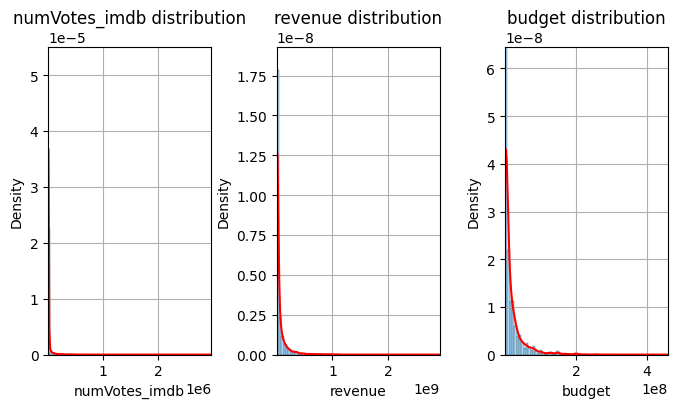

In [10]:
columns = ['numVotes_imdb', 'revenue', 'budget']
nrows = 1
ncols = len(columns)
figsize = (8,4)

plot_histograms(movies_complete, columns, nrows, ncols, figsize)

Since these distributions are highly skewed, we might take their logarithm and see whether we get more symmetric features.

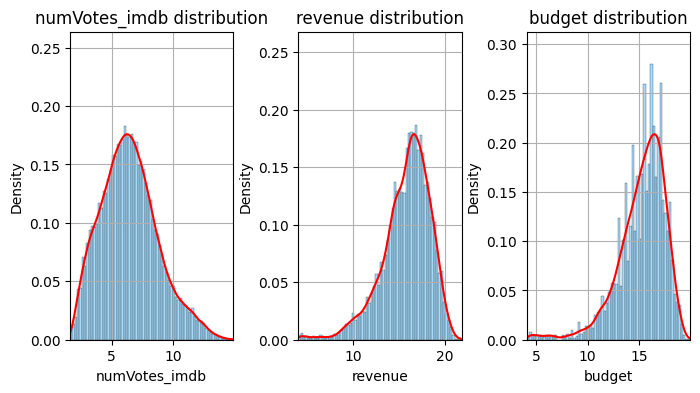

In [11]:
columns = ['numVotes_imdb', 'revenue', 'budget']
nrows = 1
ncols = len(columns)
figsize = (8,4)

df = movies_complete[columns]
df.loc[:,'numVotes_imdb'] = np.log(df['numVotes_imdb'])
df.loc[:,'revenue'] = np.log(df['revenue'])
df.loc[:,'budget'] = np.log(df['budget'])

plot_histograms(df, columns, nrows, ncols, figsize)

It seems better to work with the logarithm of such variables, so we add their log to the original dataset.

In [12]:
columns = ['numVotes_imdb', 'revenue', 'budget']

# add transformed columns
transform_columns(movies_complete, columns, np.log, substitute=False, prefix='log')

Now, since the goal of our analysis is to see what features mostly impact on a movie's success, we have to decide which factors can be considered as indicators for the success. We will use four main metrics:
- Ratings: high ratings can be regarded as positive indicators for a movie's successful outcome, whereas low ones might indicate poor performance;
- Number of ratings: this is a proxy of a movie's popularity (the more ratings, the more the movie has been watched);
- Revenue: the amount of money that the movie generated is important to determine its success.
- ROI (Return On Investments): this is the ratio between revenues and budget, and it should represent the prcentage of value that the movie has been able to generate (i.e. the fraction of invested money it was able to generate through its revenues)

Let us briefly inspect these features. In particular, we aim at:
1) Computing the ROI and inspecting its distribution;
2) Analyzing the distribution of ratings, seeing whether these data need some processing or not;
3) Inspecting the correlations among the four variables;

## 1) ROI Analysis

In [13]:
# ROI computation
revenue_col = 'revenue'
budget_col = 'budget'
movies_complete = compute_roi(movies_complete, revenue_col, budget_col)

# Display results
print(f"Number of not-NaN ROI:", movies_complete['roi_perctg'].notna().sum(),
      f"\nRepresenting the {movies_complete['roi_perctg'].notna().sum()/len(movies_complete)*100:.2f}%",
      "of the dataset.")

Number of not-NaN ROI: 6463 
Representing the 8.10% of the dataset.


In [14]:
# Brief description
movies_complete[['roi_perctg']].describe()

,roi_perctg
count,6.463000e+03
mean,1.167157e+03
std,2.761949e+04
min,2.060000e-03
25%,7.204314e+01
50%,1.911586e+02
75%,3.992325e+02
max,1.567531e+06


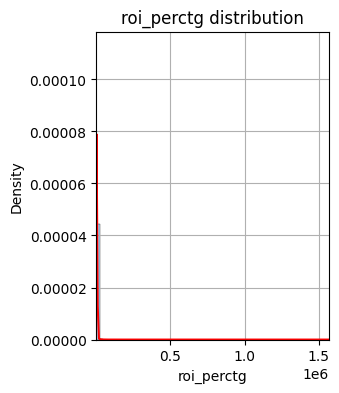

In [15]:
# Plot distribution
columns = ['roi_perctg']
nrows = 1
ncols = len(columns)
figsize = (3,4)
df = movies_complete[columns]
plot_histograms(df, columns, nrows, ncols, figsize)

Also in this case, the distribution is highly skewed, so we extract its logarithm.

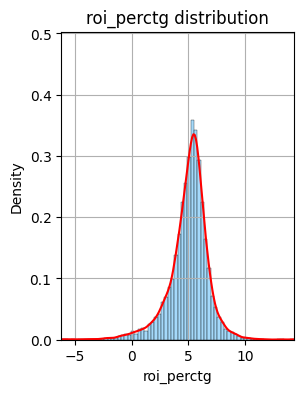

In [16]:
# Plot distribution
columns = ['roi_perctg']
nrows = 1
ncols = len(columns)
figsize = (3,4)
df = movies_complete[columns]
df.loc[:,'roi_perctg'] = np.log(df['roi_perctg'])
plot_histograms(df, columns, nrows, ncols, figsize)

# Transform all columns that have to be transformed
columns = ['numVotes_imdb', 'revenue', 'budget', 'roi_perctg']
transform_columns(movies_complete, columns, np.log, substitute=True, prefix='log')

## 2) Rating Analysis

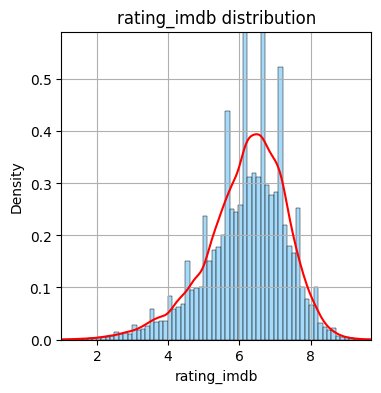

Description of ratings:

count    61331.000000
mean         6.195425
std          1.126128
min          1.000000
25%          5.600000
50%          6.300000
75%          7.000000
max          9.700000
Name: rating_imdb, dtype: float64


In [17]:
# Plot
columns = ['rating_imdb']
nrows = 1
ncols = 1
plot_histograms(movies_complete, columns, nrows, ncols, figsize=(4, 4), scale='normal')

# Print description
print("Description of ratings:\n")
print(movies_complete['rating_imdb'].describe())

The distribution is not particularly skewed and relatively symmetrical, so it doesn't need to be transformed

## 3) Correlations

Since the ROI was computed by using budget, we also have a look at the behaviour of this variable, even though it cannot be regarded as a success metric.

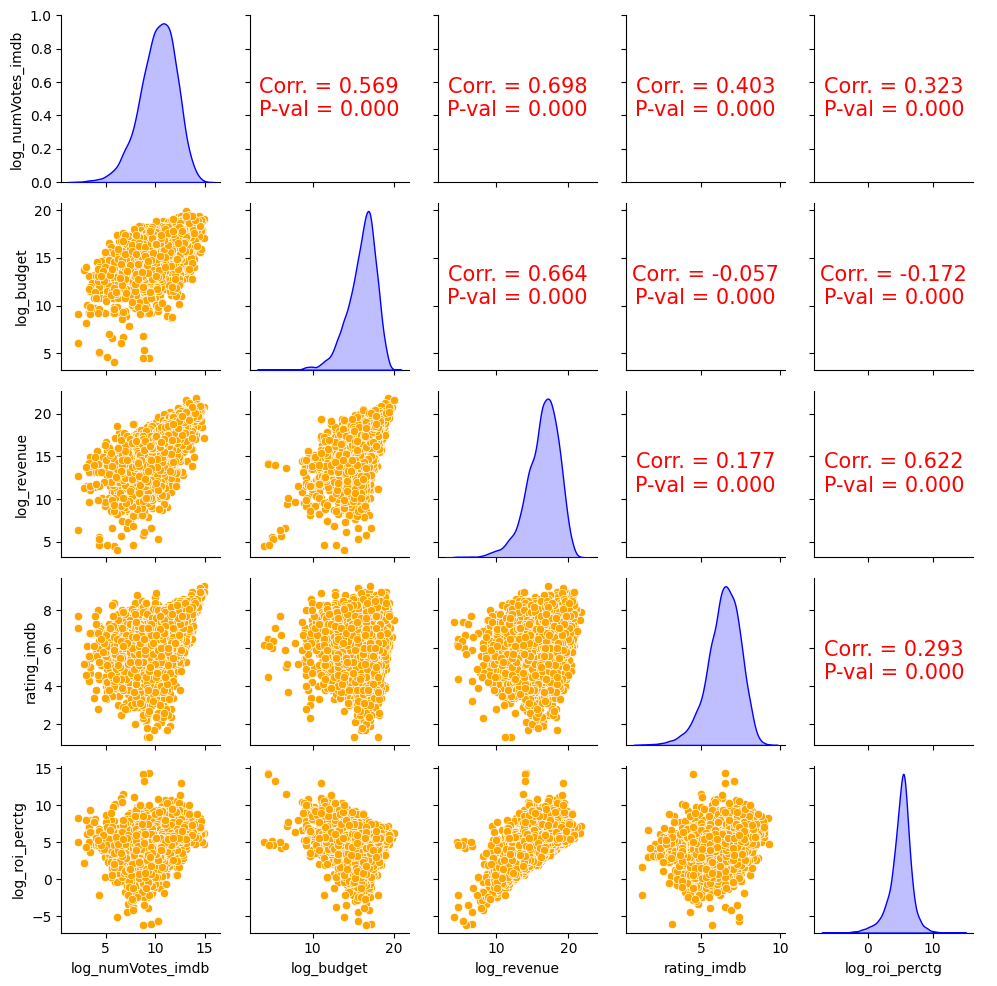

In [18]:
# Features to plot
to_keep = ['log_numVotes_imdb', 'log_budget', 'log_revenue', 'rating_imdb', 'log_roi_perctg']
height = 2

plot_gg(movies_complete, to_keep, PLOTS_FOLDER+"01GGpairs", height=height)

We notice some interesting features:
- Positive correlation between log of revenues and log of number of ratings;
- Positive correlation between log of ROI and log of number of ratings;
- Positive correlation between log of revenues and log of ROI;
- Positive correlation between log of revenues and log of budget;
- Negative correlation between log of ROI and log of budget;
- Positive correlation between log of number of ratings and log of budget;

From the Pearson correlation coefficients appearing in the plot, we see that these five covariates have some linear dependencies with each other (the stroger ones appear to be popularity-revenue, roi-revenue, budget-revenue and budget-popularity, even though we might argue that a 0.32 significant Pearson coefficient between popularity and ROI still indicates a high correlation). Since we have much more info about popularity (i.e. logarithm of the number of votes) we will stick with that metric to determine a movie's success. However, we notice two things:
1) One might try to recover missing revenues by performing a linear regression using the number of ratings. It makes sense that the number of received ratings is proportional to the revenues of a movie (here we are talking in terms of their logarithms); moreover, the above result mathematically confirms this intuition.
2) ROI and budget appear to have a negative Pearson correlation coefficient, so we will analyze this separately. 

## A small detour: investigation of ROI vs Budget

It makes sense that the lower the budget is, the higher the ROI, but still a low budget movie is expected to produce lower revenues, thus possibly diminishing the return on investments. An idea might be to divide between low budget movies and high budget ones, and see whether anything changes, and we can actually find different behaviours.

In [19]:
roi_df = movies_complete.dropna(subset="log_roi_perctg").copy(deep=True)
avg = roi_df['log_budget'].mean()

roi_df['high_budget'] = roi_df['log_budget'] >= avg

HTML file saved as plots/02_ROI_highvslow_budget.html
PDF file saved as plots/02_ROI_highvslow_budget.pdf
SVG file saved as plots/02_ROI_highvslow_budget.svg


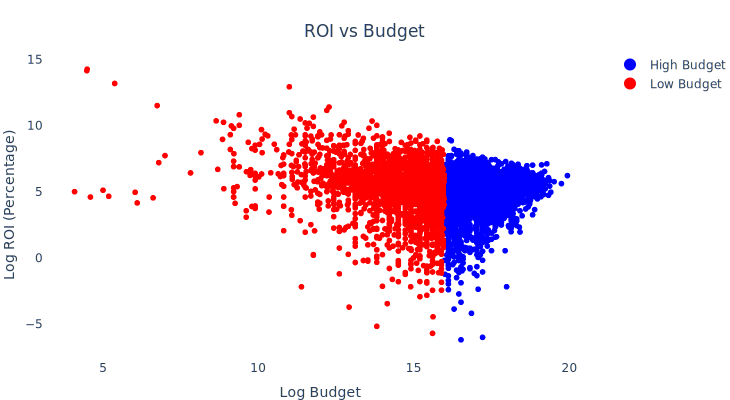

In [20]:
fig = px.scatter(
    roi_df,
    x='log_budget', 
    y='log_roi_perctg', 
    color='high_budget',
    color_discrete_map={True: 'blue', False: 'red'},
    custom_data=[roi_df['primaryTitle'], [("high" if h else "low") for h in roi_df['high_budget']]]
)

fig.update_traces(
    hovertemplate="<b>%{customdata[0]}</b><br>" +
                  "<b>Budget category:</b> %{customdata[1]}<br>" +
                  "<b>Log budget:</b> %{x:.02f}<br>" +
                  "<b>Log ROI (percentage):</b> %{y:.02f}<br>" +
                  "<extra></extra>"
)

fig.update_layout(
    title={
        'text': "ROI vs Budget",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Log Budget",
    yaxis_title="Log ROI (Percentage)",
    showlegend=True,
    width=730,
    height=400,
    dragmode=None,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    coloraxis_colorbar=dict(
        title="Budget Category", 
        tickvals=[0, 1],  
        ticktext=['Low Budget', 'High Budget'] 
    ),
    legend_itemclick=False,
    legend_itemdoubleclick=False
)

fig.update_layout(
    legend_title_text="",
    legend=dict(
        itemsizing="constant"
    )
)
fig.for_each_trace(lambda t: t.update(name="High Budget" if t.name == "True" else "Low Budget"))


save_and_display_plot(fig, "02_ROI_highvslow_budget", PLOTS_FOLDER)


We perform two different Pearson correlation tests to check whether the two correlations are indeed different.

In [21]:
corr_pearson, p_pearson = pearsonr(roi_df[roi_df['high_budget']==False].dropna(subset=['log_budget', 'log_roi_perctg'])
                                   ['log_budget'], 
                                   roi_df[roi_df['high_budget']==False].dropna(subset=['log_budget', 'log_roi_perctg'])
                                   ['log_roi_perctg'])
statistic_name = 'Pearson correlation'
alpha = 0.05
null_hyp = 'Features are not correlated'
print(f"Testing linear dependence for log_roi_perctg and log_budget for low budget movies...\n")
print_tests_results(corr_pearson, p_pearson, statistic_name, null_hyp, alpha)

Testing linear dependence for log_roi_perctg and log_budget for low budget movies...

With a value of -0.29 for Pearson correlation  and a p-value of 0.00, 
we CAN significantly REJECT the null hypothesis (i.e. " Features are not correlated ")


In [22]:
corr_pearson, p_pearson = pearsonr(roi_df[roi_df['high_budget']==True].dropna(subset=['log_budget', 'log_roi_perctg'])
                                   ['log_budget'], 
                                   roi_df[roi_df['high_budget']==True].dropna(subset=['log_budget', 'log_roi_perctg'])
                                   ['log_roi_perctg'])
statistic_name = 'Pearson correlation'
alpha = 0.05
null_hyp = 'Features are not correlated'
print(f"Testing linear dependence for log_roi_perctg and log_budget for high budget movies\n")
print_tests_results(corr_pearson, p_pearson, statistic_name, null_hyp, alpha)

Testing linear dependence for log_roi_perctg and log_budget for high budget movies

With a value of 0.16 for Pearson correlation  and a p-value of 0.00, 
we CAN significantly REJECT the null hypothesis (i.e. " Features are not correlated ")


Apparently, there seems to be a high distinction between the two populations. In case of low budget movies, the ROI is negatively correlated with the budget (in terms of their log), meaning that, within these data, to higher budgets we find corresponding lower returns. In high budget movies, instead, the situation is the opposite, even if one might argue that a 0.12 correlation coefficient is low (i.e. no strong correlation).

# The analysis of success

Now that we have explored the starting datasets, we can start a more deep and particular analysis of what features seem to make a movie successful. Given the above results, we will mainly consider as success metric the number of votes a movie received (or better its logarithm), a metric which we will often refer to as 'popularity' (it makes sense that the number of reviews a movie received is regarded as measure of its popularity).

The following part of the notebook will be motivated by the following two research questions:
1) How much does the country where the movie was produced impact on its popularity? Often the most famous movies come from Hollywood, suggesting that the most popular ones are produced in the US. Can we confirm this expectation? Is there a causal relation between production country and popularity?
2) Is the genre of a movie relevant for its success? Are there preferred genres by the public that appear to guarantee better results in advance?
3) What's the influence of the cast on a movie's "share"? We will especially analyze the cast in terms of:
- Actors'age (on one hand, an old actor might be more experienced and famous, so he/she might be better at acting and might attract watchers by the only power of his/her fame; on the other hand, young people might prefer 'seeing themselves' on the screen, and even an older public can be more attracted by young actors' novelty);
- Diversity in the actors'country of origin (maybe having a multi-ethnical cast leads more people to feel represented somehow);
- Popularity of its director.
4) What is the impact of the producing company on the popularity of the movie? There is the possibility that, as it happens in many other artistic works (e.g. songs), people regard a successful producer as a warranty of quality. However, it might happen that little companies are more free in their works, being less constrained by heavy obligations due to investors, politics,...

## 1) Production Countries

To begin, we investigate the number of movies each country has "hosted". Since the data about the country of production was not very consistent, we manually wrote a dictionary to map non-standard country names to the correct ones. For example, we map "West Germany" to "Germany", "Scotland" to "United Kingdom", "Polish People's Republic" to "Poland", and so on. This allows us to have a consistent set of countries to work with.

In [23]:
# Define datasets for countries mapping
countries_mapper_df = pd.read_csv(DATA_FOLDER + "/countries_names_mapper.csv", dtype=str)
countries_mapper_dict = dict(zip(countries_mapper_df.iloc[:, 0], countries_mapper_df.iloc[:, 1]))

# Associate to each country the number of movies it "hosted"
movies_complete["countries"] = movies_complete.countries.apply(map_country_list)
country_vs_pop = movies_complete[["countries", "log_numVotes_imdb"]].dropna(subset="countries").copy(deep=True)
country_vs_pop["countries"] = country_vs_pop["countries"].apply(lambda x: x.split(","))
country_vs_pop = country_vs_pop.explode("countries", ignore_index=True)
countries_counts = country_vs_pop.countries.value_counts().reset_index()

# Display results
countries_counts.head()

NameError: name 'countries_mapper_dict' is not defined

In [ ]:
# Plot map with the number of movies per country

countries_counts['log_count'] = np.log10(countries_counts['count'].replace(0, np.nan))

fig = px.choropleth(
    countries_counts,
    locations="countries",
    locationmode="country names",
    color="log_count",
    hover_name="countries",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Number of Instances per Country (Log Scale)"
)
fig.update_traces(
    hovertemplate='<b>%{location}</b><br>Count: %{customdata}'
)
fig.update_traces(customdata=countries_counts['count'])

colorbar_ticks = np.log10([1, 10, 100, 1000, 10000])
colorbar_ticktext = ['1', '10', '100', '1k', '10k']
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Count",
        tickvals=colorbar_ticks,
        ticktext=colorbar_ticktext
    )
)

fig.update_geos(
    projection_type="miller"
)

fig.update_layout(
    width=730,
    height=510,
    title={
        'text': "Number of movies per country",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_map_country_num", PLOTS_FOLDER)

In [ ]:
# Create bar plot with the number of movies per country

fig = go.Figure()

fig.add_trace(go.Bar(
    x=countries_counts.head(19)["countries"],
    y=countries_counts.head(19)["count"],
        marker=dict(
        color=countries_counts.head(20)["count"].apply(np.log10),
        colorscale=px.colors.sequential.Plasma,
        cmin=0
    ),
    hovertemplate="<b>Country:</b> %{x}<br>" +
                  "<b>Count:</b> %{customdata}<br>" +
                  "<extra></extra>"
))
fig.update_traces(customdata=countries_counts.head(19)["count"].astype(str))

fig.update_layout(
    title={
        'text': "Number of movies per country",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Country",
    yaxis_title="Count",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    showlegend=False,
    width=730,
    height=330,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_country_count_bar", PLOTS_FOLDER)

Now, we visualize the average popularity of movies for each country.

In [ ]:
# Drop NaNs
country_vs_pop = country_vs_pop.dropna(subset="log_numVotes_imdb")

# Group by country and take the count, and mean and std of popularity
cou_pop_avg_df = country_vs_pop.groupby("countries").agg(
    count=("log_numVotes_imdb", "count"),
    mean=("log_numVotes_imdb", "mean"),
    std=("log_numVotes_imdb", "std")
).reset_index()
cou_pop_avg_df = cou_pop_avg_df[cou_pop_avg_df["count"] > 50].sort_values(by="mean", ascending=False)

# Display results
cou_pop_avg_df.head()

In [ ]:
# Plot map with the average popularity of movies per country

fig = px.choropleth(
    cou_pop_avg_df,
    locations="countries",
    locationmode="country names",
    color="mean",
    hover_name="countries",
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.update_traces(
    hovertemplate='<b>%{location}</b><br>Avg popularity: %{customdata}'
)
fig.update_traces(customdata=cou_pop_avg_df['mean'].apply(lambda x: f"{x:.2f}"))

fig.update_geos(
    projection_type="miller"
)

fig.update_layout(
    width=730,
    height=510,
    title={
        'text': "Average popularity per country",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_map_country_avg", PLOTS_FOLDER)

In [ ]:
# Create bar plot with the average popularity of movies per country. We plot only the best and the worst 10 countries

fig = go.Figure()

# create temporary dataframe with an empty row to separate the two groups
mask = [True] * 10 + [False] * (len(cou_pop_avg_df) - 20) + [True] * 10
barplot_df = cou_pop_avg_df.iloc[mask].copy(deep=True)
min_mean = min(barplot_df["mean"])
empty_row = pd.DataFrame({'countries': [""], 'count': 0, 'mean': 0, 'std': 0})
barplot_df = pd.concat([barplot_df.iloc[:10], empty_row, barplot_df.iloc[10:]], axis=0)

fig.add_trace(go.Bar(
    x=barplot_df["countries"],
    y=barplot_df["mean"],
        marker=dict(
        color=barplot_df["mean"][[True] * 10 + [False] + [True] * 10],
        colorscale=px.colors.sequential.Plasma,
    ),
    hovertemplate="<b>Country:</b> %{x}<br>" +
                  "<b>Avg popularity:</b> %{customdata}<br>" +
                  "<extra></extra>"
))
fig.update_traces(customdata=barplot_df["mean"].apply(lambda x: f"{x:.2f}"))

fig.update_layout(
    title={
        'text': "Average popularity per country",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Country",
    yaxis_title="Average popularity",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, range=[3.5, 8.1]),
    showlegend=False,
    width=730,
    height=330,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_country_avg_bar", PLOTS_FOLDER)

In order to quantitatively measure the impact of a country on a movie's popularity, we perform a linear regression on log of number of reviews with respect to the country. Note that in our case we cannot use `pandas.get_dummies`, since one movie can potentialy be produced in multiple countries.

In [ ]:
# Create dummy variables for countries
country_vs_pop = movies_complete[["countries", "log_numVotes_imdb"]].dropna().copy(deep=True)
countries_list = list(cou_pop_avg_df.countries.values)
dummy_col_names = ["country_"+c.replace(" ", "_") for c in countries_list]
country_to_dummy = dict(zip(countries_list, dummy_col_names))
dummy_to_country = dict(zip(dummy_col_names, countries_list))
country_vs_pop_dummy = pd.DataFrame(
    {name: False for name in dummy_col_names},
    index=country_vs_pop.index
)
for i, row in country_vs_pop.iterrows():
    c_list = row["countries"].split(",")
    for c in c_list:
        if c in countries_list:
            country_vs_pop_dummy.loc[i, country_to_dummy[c]] = True
country_vs_pop_dummy["log_numVotes_imdb"] = country_vs_pop["log_numVotes_imdb"]

# Perform regression
formula = "log_numVotes_imdb ~ " + " + ".join([f"C({cc})" for cc in dummy_col_names])
mod = smf.ols(formula=formula, data=country_vs_pop_dummy)
res = mod.fit()

# Display results
print(res.summary())

In the following plot, we visualize each country's coefficient in the regression. Notice that US, as initially suggested, seem to have a quite impactful weight in the model.

In [ ]:
# Plot coefficients of logistic regression
coefficients = res.params.values[1:]
variables = res.params.index[1:]
standard_errors = res.bse.values[1:]
p_values = res.pvalues[1:]

sorted_coefficients, sorted_variables, sorted_std_err, sorted_p_values = zip(*sorted(zip(coefficients, variables, standard_errors, p_values), key=lambda x: x[0]))

fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_coefficients,
    y=sorted_variables,
    error_x=dict(
        type='data',
        array=[2 * err for err in sorted_std_err],
        visible=True
    ),
    orientation='h',
    marker=dict(
        color=sorted_coefficients,
        colorscale=px.colors.sequential.Plasma
    ),
    hovertemplate="<b>Country:</b> %{customdata[0]}<br>" +
              "<b>Coefficient:</b> %{x:.2f}<br>" +
              "<b>Standard Error:</b> %{customdata[1]:.2f}<br>" +
              "<extra></extra>",
    customdata=np.array([
        [dummy_to_country[v[2:-9]] for v in sorted_variables],
        sorted_std_err
    ]).T
))

fig.add_shape(
    type="line",
    x0=0, y0=-0.5,
    x1=0, y1=len(sorted_variables) - 0.5,
    line=dict(color="black", width=1)
)

fig.update_layout(
    title={
        'text': "OLS coefficients per country",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Coefficient",
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(sorted_variables))),
        ticktext=[dummy_to_country[v[2:-9]].replace("United States of America", "United States<br>of America") for v in sorted_variables]
    ),
    xaxis=dict(showgrid=True, zeroline=False),
    showlegend=False,
    width=365,
    height=1000,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_country_ols", PLOTS_FOLDER)

We see here that the movies from the usa are generally very popular and that the relative weight is high in the linear regression model.

We aim at exploring a possible causality between the fact that a movie was produced in the USA and its popularity. To do so, we first compute, using a logistic regression model on all covariates but from country, the probability that a movie of is produced in the US. Then, we use propensity score matching to match movies with the same "probability" of being produced in the USA. Finally, we investigate with a t-test for the difference in averages whether the popularity is actually different among US and non-US movies.

In order to proceed, however, we first have to clean the data about the genres. Since the data was not very consistent, we manually wrote a dictionary to map genres to one or more genres within a limited list of relevant genres. For example, we map "science fiction" to "sci-fi", "autobiography" to "biography", "romantic comedy" to "romance" and "comedy", and so on. This allows us to have a consistent set of genres to work with.

In [ ]:
# Create genre variable
genres_mapper_df = pd.read_csv(DATA_FOLDER + "/genres_mapper.csv", dtype=str)
genres_mapper_dict = dict(zip(genres_mapper_df.iloc[:, 0].apply(lambda x: x.lower()), genres_mapper_df.iloc[:, 1]))

movies_complete["genres_original"] = movies_complete.genres_original.apply(map_genres_list)
movies_complete["genres_wikidata"] = movies_complete.genres_wikidata.apply(map_genres_list)
movies_complete["genres_IMDB_TMDB"] = movies_complete.genres_IMDB_TMDB.apply(map_genres_list)

movies_complete["genres"] = movies_complete.apply(lambda row: merge_comma_sep
                                                  (merge_comma_sep(row["genres_original"], row["genres_wikidata"]), 
                                                   row["genres_IMDB_TMDB"]), axis=1)

In [ ]:
# Preprocess all covariates to perform a logistic regression
cols = ["release_year", "runtimeMinutes", "genres", "log_budget", "countries", "log_numVotes_imdb"]
propensity_df = movies_complete[cols].dropna().copy(deep=True)
propensity_df["runtimeMinutes"] = propensity_df["runtimeMinutes"].astype(float)
for col in ["release_year", "runtimeMinutes", "log_budget"]:
    propensity_df[col] = (propensity_df[col] - propensity_df[col].mean())/propensity_df[col].std()

# Create dummy variables, again we cant use pandas.get_dummies, since one film can belong to multiple genres
genres_list = ['music', 'family', 'thriller', 'comedy', 'drama', 'documentary', 'biography', 'western',
               'adventure', 'mystery', 'action', 'history', 'war', 'animation', 'crime', 'horror', 'sport',
               'romance', 'sci-fi', 'fantasy']
dummy_col_names = ["genre_"+g.replace("-", "") for g in genres_list]
genre_to_dummy = dict(zip(genres_list, dummy_col_names))
dummy_to_genre = dict(zip(dummy_col_names, genres_list))
propensity_df_dummy = pd.DataFrame(
    {name: False for name in dummy_col_names},
    index=propensity_df.index
)
for i, row in propensity_df.iterrows():
    g_list = row["genres"].split(",")
    for g in g_list:
        propensity_df_dummy.loc[i, genre_to_dummy[g]] = True
for col in ["release_year", "runtimeMinutes", "log_budget", "log_numVotes_imdb"]:
    propensity_df_dummy[col] = propensity_df[col]
propensity_df_dummy["country_USA"] = propensity_df["countries"].apply(lambda x: 1 if x == "United States of America" else 0)

# Logistic regression
formula = "country_USA ~ " + " + ".join([f"C({gg})" for gg in dummy_col_names]) + " + release_year + runtimeMinutes + log_budget"
mod = smf.logit(formula=formula, data=propensity_df_dummy)
res = mod.fit()
propensity_df_dummy['propensity_score'] = res.predict()

# Display results
print(res.summary())

In [ ]:
# Discriminate based on US and non-US
USA_true = propensity_df_dummy[propensity_df_dummy['country_USA']==1][['country_USA', 'propensity_score', 'log_numVotes_imdb']].copy(deep=True)
USA_false = propensity_df_dummy[propensity_df_dummy['country_USA']==0][['country_USA', 'propensity_score', 'log_numVotes_imdb']].copy(deep=True)

print(f"Number of samples in USA_true: {len(USA_true)}")
print(f"Number of samples in USA_false: {len(USA_false)}")

In [ ]:
# Convert to numpy arrays
true_ids = USA_true.index.to_numpy()
false_ids = USA_false.index.to_numpy()
true_scores = USA_true['propensity_score'].to_numpy()
false_scores = USA_false['propensity_score'].to_numpy()

# Compute pairwise similarities
similarity_matrix = 1 - np.abs(true_scores[:, None] - false_scores[None, :])

# Filter pairs with similarity > 0.90
rows, cols = np.where(similarity_matrix > 0.90)

# Create an edge list for the graph
edges = [(true_ids[row], false_ids[col], similarity_matrix[row, col]) for row, col in zip(rows, cols)]

# Create the graph and add edges
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Perform greedy matching, we tried max_weight_matching is too slow, we belive the complexity
# of max_weight_matching is too high so it wouldn't help much to look for a more efficient implementation
edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
matching = set()
matched_nodes = set()

for u, v, data in edges:
    if u not in matched_nodes and v not in matched_nodes:
        matching.add((u, v))
        matched_nodes.update([u, v])

# Display result
n_matches = len(matching)
print(f"Number of successful matches: {n_matches}")

In [ ]:
# Create balanced dataset and compute count and average log popularity between US and non-US movies
balanced_USA = propensity_df_dummy.loc[[x for x in matched_nodes]][['country_USA', 'propensity_score', 'log_numVotes_imdb']].copy(deep=True)

balanced_USA_avg = balanced_USA.groupby("country_USA").agg(
    count=("log_numVotes_imdb", "count"),
    mean=("log_numVotes_imdb", "mean")
).reset_index()

balanced_USA_avg

In [ ]:
# Create bar plot with the two means
fig = go.Figure()

fig.add_trace(go.Bar(
    x=["Produced<br>in the USA", "Produced<br>outside the USA"],
    y=list(reversed(balanced_USA_avg["mean"])),
        marker=dict(
        color=["red", "blue"]
    ),
    hovertemplate="<b>%{x}</b><br>" +
                  "<b>Avg popularity:</b> %{y:.02f}<br>" +
                  "<b>Count:</b> %{customdata}<br>" +
                  "<extra></extra>"
))
fig.update_traces(customdata=list(reversed(balanced_USA_avg["count"])))

fig.update_layout(
    title={
        'text': "Average popularity USA vs non-USA",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title="Average popularity",
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, range=[8.5, 9.75]),
    showlegend=False,
    width=365,
    height=330,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_country_propensity_bar", PLOTS_FOLDER)

In [ ]:
# Perform the t-test
test_result = stats.ttest_ind(
    balanced_USA.loc[balanced_USA['country_USA'] == 1]['log_numVotes_imdb'],
    balanced_USA.loc[balanced_USA['country_USA'] == 0]['log_numVotes_imdb']
)

# Print explanation of the result
print(f"Average popularity for non-US movies: {balanced_USA_avg.iloc[0,2]:.4f}")
print(f"Average popularity for US movies: {balanced_USA_avg.iloc[1,2]:.4f}")
print(f"T-Test Results:\n"
      f"Test Statistic: {test_result.statistic:.4f}\n"
      f"P-Value: {test_result.pvalue:.4e}\n"
      f"Degrees of Freedom: {test_result.df:.0f}"
)

Being the average popularity higher for US movies, and having performed the above t-test with very low p-value, we can significantly conclude that US production will lead to higher popularity.

# 2) Genre Analysis

We recall that in the previous section we cleaned the data about the genres. We mapped every genre in the dataset to one or more genres within a limited list of relevant genres. For example, we maped "science fiction" to "sci-fi", "autobiography" to "biography", "romantic comedy" to "romance" and "comedy", and so on. This allows us to have a consistent set of genres to work with.

We would like to discover which genres display the biggest average popularities.

We start by looking at the frequencies of the genres accross the dataset.

In [ ]:
genres_vs_pop = movies_complete[["genres", "log_numVotes_imdb"]].dropna(subset="genres").copy(deep=True)
genres_vs_pop["genres"] = genres_vs_pop["genres"].apply(lambda x: x.split(","))
genres_vs_pop = genres_vs_pop.explode("genres", ignore_index=True)

genres_counts = genres_vs_pop.genres.value_counts().reset_index()
genres_counts

In [ ]:
# Create bar plot with the number of movies per genre

fig = go.Figure()

fig.add_trace(go.Bar(
    x=genres_counts["genres"],
    y=genres_counts["count"],
        marker=dict(
        color=genres_counts["count"].apply(np.log10),
        colorscale='Bluered',
        cmin=0
    ),
    hovertemplate="<b>Genre:</b> %{x}<br>" +
                  "<b>Count:</b> %{customdata}<br>" +
                  "<extra></extra>"
))
fig.update_traces(customdata=genres_counts["count"].astype(str))

fig.update_layout(
    title={
        'text': "Number of movies per genre",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Genre",
    yaxis_title="Count",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    showlegend=False,
    width=730,
    height=370,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_genre_count_bar", PLOTS_FOLDER)

We now compute the average popularity for each genre and plot the results through a barplot.

In [ ]:
# compute count and average log popularity per genre
genres_vs_pop = genres_vs_pop.dropna(subset="log_numVotes_imdb")

gen_pop_avg_df = genres_vs_pop.groupby("genres").agg(
    count=("log_numVotes_imdb", "count"),
    mean=("log_numVotes_imdb", "mean")
).reset_index()
gen_pop_avg_df = gen_pop_avg_df.sort_values(by="mean", ascending=False).reset_index()

# Create bar plot with the average popularity of movies per genre
fig = go.Figure()

fig.add_trace(go.Bar(
    x=gen_pop_avg_df["genres"],
    y=gen_pop_avg_df["mean"],
        marker=dict(
        color=gen_pop_avg_df["mean"],
        colorscale='Bluered',
    ),
    hovertemplate="<b>Genre:</b> %{x}<br>" +
                  "<b>Avg pupularity:</b> %{y:.02f}<br>" +
                  "<extra></extra>"
))

fig.update_layout(
    title={
        'text': "Average popularity per genre",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Genre",
    yaxis_title="Average popularity",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, range=[5.3, 8.3]),
    showlegend=False,
    width=730,
    height=330,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_genre_avg", PLOTS_FOLDER)

Sci-fi and fantasy are the most popular types of movies, whereas for genres linke music or documentary, we find lower popularities.

We now try an ordinary least squares regression to understand the impact of each genre on the model. Naturally, we use the average popularity as response variable.

In [ ]:
# Preprocess all covariates to perform a logistic regression
genres_vs_pop = movies_complete[["genres", "log_numVotes_imdb"]].dropna().copy(deep=True)
genres_list = list(gen_pop_avg_df.genres.values)
dummy_col_names = ["genre_"+g.replace("-", "") for g in genres_list]

genre_to_dummy = dict(zip(genres_list, dummy_col_names))
dummy_to_genre = dict(zip(dummy_col_names, genres_list))

# Create dummy variables, again we cant use pandas.get_dummies, since one film can belong to multiple genres
genre_vs_pop_dummy = pd.DataFrame(
    {name: False for name in dummy_col_names},
    index=genres_vs_pop.index
)
for i, row in genres_vs_pop.iterrows():
    g_list = row["genres"].split(",")
    for g in g_list:
        genre_vs_pop_dummy.loc[i, genre_to_dummy[g]] = True
genre_vs_pop_dummy["log_numVotes_imdb"] = genres_vs_pop["log_numVotes_imdb"]

# Ordinary least-squares
formula = "log_numVotes_imdb ~ " + " + ".join([f"C({gg})" for gg in dummy_col_names])
mod = smf.ols(formula=formula, data=genre_vs_pop_dummy)
res = mod.fit()

# Display results
print(res.summary())

Even though the model cannot explain the whole variability of the dataset, with an R-squared of slightly more than 20%, we still found many significant coefficients as all p-values are smaller than 10^-4. In the following plot, we display the coefficients magnitude for each genre.

In [ ]:
# Plot coefficients of logistic regression
coefficients = res.params.values[1:]
variables = res.params.index[1:]
standard_errors = res.bse.values[1:]
p_values = res.pvalues[1:]

sorted_coefficients, sorted_variables, sorted_std_err, sorted_p_values = zip(*sorted(zip(coefficients, variables, standard_errors, p_values), key=lambda x: x[0]))

fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_coefficients,
    y=sorted_variables,
    error_x=dict(
        type='data',
        array=[2 * err for err in sorted_std_err],
        visible=True
    ),
    orientation='h',
    marker=dict(
        color=sorted_coefficients,
        colorscale='Bluered',
    ),
    hovertemplate="<b>Genre:</b> %{y}<br>" +
              "<b>Coefficient:</b> %{x:.2f}<br>" +
              "<b>Standard Error:</b> %{customdata:.2f}<br>" +
              "<extra></extra>",
    customdata=sorted_std_err
))

fig.add_shape(
    type="line",
    x0=0, y0=-0.5,
    x1=0, y1=len(sorted_variables) - 0.5,
    line=dict(color="black", width=1)
)

fig.update_layout(
    title={
        'text': "OLS coefficients per genre",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Coefficient",
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(sorted_variables))),
        ticktext=[dummy_to_genre[v[2:-9]] for v in sorted_variables]
    ),
    xaxis=dict(showgrid=True, zeroline=False),
    showlegend=False,
    width=365,
    height=570,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "03_genre_ols", PLOTS_FOLDER)

# Cast Analysis

Naturally, there are many aspects of the movie's cast that could be explored to explain its impact on the popularity of it. We will specifically fosus on some of them:
- How much is the age of actors appearing in a movie relevant for its success? On one hand, an old actor might be more experienced and famous, so he/she might be better at acting and might attract watchers by the only power of his/her fame; On the other hand, young people might prefer 'seeing themselves' on the screen, and even an older public can be more attracted by young actors' novelty.
- Can we see any correlation between the diversity, in terms of ethnicity, of professionals involved in the movie and its popularity? Probably, a famous italian actor starring in a US movie is going to push the italian public to watch it, resulting in a bigger number of reviews.
- Is the gender distribution among the cast relevant for the public satisfaction?
- Do the popularity of actors and directors involved in a movie production influence its popularity?

First of all, we need a complete dataset, associating all necessary information of movies, actors and directors.

In [ ]:
# create completely merged dataframe
countries_mapper_df = pd.read_csv(DATA_FOLDER + "/actor_countries_names_mapper.csv", dtype=str, header=None)
countries_mapper_dict = dict(zip(countries_mapper_df.iloc[:, 0], countries_mapper_df.iloc[:, 1]))
wikidata_people_country["country"] = wikidata_people_country["country"].apply(lambda x: pd.NA if pd.isna(x) or x not in countries_mapper_dict.keys()
                                                                               else countries_mapper_dict[x])

complete_df = pd.merge(
    pd.merge(
        pd.merge(
            movies_complete, 
            movie_actor_complete, 
            on='freebase_id_movie',
            how='left',
            suffixes=('_', '')
        ), 
        people_complete, 
        on='univocal_id_actor', 
        how='left',
        suffixes=('_', '')
    ), 
    wikidata_people_country, 
    left_on='wikidata_id_actor',
    right_on='wikidataID',
    how='left',
    suffixes=('_', '')
)

cols = ['freebase_id_movie', 'primaryTitle', 'release_year', 'runtimeMinutes', 'original_language', 'countries',
        'rating_imdb', 'log_numVotes_imdb', 'log_revenue', 'log_budget', 'genres', 'univocal_id_actor', 'name_actor',
        'role', 'ordering', 'nameSurname_actor', 'givenName_actor', 'familyName_actor', 'gender', 'year_of_birth',
        'year_of_death', 'citizenship', 'placeOfBirth', 'country', 'continent']
complete_df = complete_df[cols].copy(deep=True)

In [ ]:
# Compute mean age and its standard deviation for each movie and merge 
mean_age_df = compute_age(complete_df, 'year_of_birth', 'release_year', 'age_at_release')
mean_age_df = mean_age_df.dropna(subset = 'age_at_release')
mean_age_df = mean_age_df.groupby('freebase_id_movie').agg( mean_age=('age_at_release','mean'), 
                                                                   std_age=('age_at_release','std')).reset_index()
movies_complete = pd.merge(movies_complete, mean_age_df, how="left", on="freebase_id_movie")

To quantitatively assess the diversity of the cast within a movie, we used Shannon entropy. Shannon entropy measures the diversity of a dataset by quantifying its uncertainty or randomness. A higher Shannon entropy value indicates a more diverse cast, as it reflects a more even distribution of among many nationalities. The Shannon entropy is given by the formula
$$
H = - \sum_{i=1}^{n} p_i \log(p_i)
$$
- $p_i$ is the proportion of individuals in category $i$,
- $n$ is the total number of categories.

In our case the categories are the countries of birth.

We also compute the number of different countries of birth as another measure of diversity within the cast.

In [ ]:
# Compute Shannon Entropy and country count in actors for each movie
def shannon_entropy(data):
    values, counts = np.unique(data, return_counts=True)
    freq = counts / counts.sum()
    return stats.entropy(freq, base=2)

entropies_df = complete_df[complete_df.role != "director"].dropna(subset="country").groupby(by="freebase_id_movie").agg(
    cast_country_count=('country', pd.Series.nunique),
    cast_country_entropy=('country', shannon_entropy)
).reset_index()

movies_complete = pd.merge(movies_complete, entropies_df, how="left", on="freebase_id_movie")

Then, we analise the gender distribution. The female_score is the proportion of females with the cast. Instead gender_score measure how far from 50% the gender balance within the cast is.

In [ ]:
# compute female score and gender score
def gender_balance_score(data):
    if len(data) < 4:
        return pd.NA
    values, counts = np.unique(data, return_counts=True)
    freq_dict = dict(zip(values, counts / counts.sum()))

    return freq_dict["F"] if "F" in freq_dict.keys() else 0.

gender_scores_df = complete_df[complete_df.role != "director"].dropna(subset="gender") \
            .groupby(by="freebase_id_movie").agg({'gender': gender_balance_score}).reset_index()

gender_scores_dict = dict(zip(gender_scores_df.iloc[:, 0], gender_scores_df.iloc[:, 1]))

movies_complete["female_score"] = movies_complete.freebase_id_movie.apply(lambda x: gender_scores_dict[x] if x in gender_scores_dict.keys() else pd.NA)
movies_complete["female_score"] = pd.to_numeric(movies_complete["female_score"], errors='coerce')

movies_complete["gender_score"] = movies_complete["female_score"].apply(lambda x: pd.NA if pd.isna(x) else 2*abs(x-0.5))
movies_complete["gender_score"] = pd.to_numeric(movies_complete["gender_score"], errors='coerce')

We finally compute, for each director and actor, the fame measured as the number of movies he/she has contributed to. Each movie is then assigned 'actor_fame' and 'director_fame' values that are the maximum 'actor_fame' and 'director_fame' within the cast. Behind this approach lies the resoning according to which a single famous actor/director could significantly impact the popularity of a movie, regardless of the others' fames. If we used the average to aggregate the fames, we would risk to classify poorly a movie with several unknown actors and only one famous actor and to classify mush better a movie with only one famous actor.

In [ ]:
# compute director fames
directors_num_dict = (complete_df[complete_df.role == "director"][["freebase_id_movie", "univocal_id_actor"]]
                        .drop_duplicates()["univocal_id_actor"].value_counts().to_dict())

complete_df["director_fame"] = complete_df.univocal_id_actor.apply(lambda x: directors_num_dict[x] if x in directors_num_dict.keys() else 0)
num_df = complete_df.groupby(by="freebase_id_movie").agg({'director_fame': 'max'}).reset_index()

num_dict = dict(zip(num_df.iloc[:, 0], num_df.iloc[:, 1]))

movies_complete["director_fame"] = movies_complete.freebase_id_movie.apply(lambda x: num_dict[x] if x in num_dict.keys() else 0).replace(0, 1)
movies_complete["director_fame_bool"] = movies_complete["director_fame"] > 1

In [ ]:
# compute actors fames
actors_num_dict = (complete_df[complete_df.role != "director"][["freebase_id_movie", "univocal_id_actor"]]
                        .drop_duplicates()["univocal_id_actor"].value_counts().to_dict())

complete_df["actor_fame"] = complete_df.univocal_id_actor.apply(lambda x: actors_num_dict[x] if x in actors_num_dict.keys() else 0)
num_df = complete_df.groupby(by="freebase_id_movie").agg({'actor_fame': 'max'}).reset_index()

num_dict = dict(zip(num_df.iloc[:, 0], num_df.iloc[:, 1]))

movies_complete["actor_fame"] = movies_complete.freebase_id_movie.apply(lambda x: num_dict[x] if x in num_dict.keys() else 0).replace(0, 1)
movies_complete["actor_fame_bool"] = movies_complete["actor_fame"] > 1

In [ ]:
# check for missing values among these new statistics
statistics = ["cast_country_count", "cast_country_entropy", "female_score", "gender_score", "mean_age", "std_age", "actor_fame",
              "actor_fame_bool", "director_fame", "director_fame_bool"]

print_missing_stats(movies_complete[statistics])

Now that the dataset is ready, we can first see how much the single variables appear to be correlated to the popularity according to Spearman and Pearson coefficients.

In [ ]:
# compute Pearson and Spearman correlations for each statistic
correlation_df = pd.DataFrame(0., index=statistics, columns=["pearsonr", "pearsonr_pvalue", "spearmanr", "spearmanr_pvalue"])

for s in statistics:
    df = movies_complete.dropna(subset=[s, "log_numVotes_imdb"], how="any")
    res = stats.pearsonr(df[s].astype(float).values, df["log_numVotes_imdb"].values)
    correlation_df.loc[s, "pearsonr"] = res[0].item()
    correlation_df.loc[s, "pearsonr_pvalue"] = res[1].item()
    res = stats.spearmanr(df[s].astype(float).values, df["log_numVotes_imdb"].values)
    correlation_df.loc[s, "spearmanr"] = res[0].item()
    correlation_df.loc[s, "spearmanr_pvalue"] = res[1].item()

correlation_df

We plot the Pearson coefficients

In [ ]:
# Plot Pearson correlations
fig = go.Figure()

fig.add_trace(go.Bar(
    x=list(reversed(correlation_df.pearsonr.values)),
    y=list(reversed(statistics)),
    orientation='h',
    marker=dict(
        color=list(reversed(correlation_df.pearsonr.values)),
        colorscale='Viridis',
    ),
    hovertemplate="<b>Statistic:</b> %{y}<br>" +
              "<b>Pearson coefficient:</b> %{x:.2f}<br>" +
              "<extra></extra>"
))

fig.add_shape(
    type="line",
    x0=0, y0=-0.5,
    x1=0, y1=len(statistics) - 0.5,
    line=dict(color="black", width=1)
)

fig.update_layout(
    title={
        'text': "Pearson coefficients on cast statistics",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Coefficient",
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(statistics))),
        ticktext=list(reversed(statistics))
    ),
    xaxis=dict(showgrid=True, zeroline=False, range=[-0.12, 0.31]),
    showlegend=False,
    width=365,
    height=530,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "04_cast_pearson", PLOTS_FOLDER)

The variability in the ethnicity of a movie's cast is positively correlated with its popularity. This might both be because movies with a bigger cast are also the ones with higher budgets and better production, and for this reason they become more popular. Another reason could be that movies with more internationally diverse casts tend to resonate better with audiences.

Also std_age seems to be positively correlated with a movie's success. The same goes for the fame's metrics.

The idea now would be to train a linear model on these statistics, but before we check for colinearities since we expect some of these statistcs to be correlated with each other.

In [ ]:
correlation_matrix = movies_complete[statistics].dropna().corr()

# Create a heatmap
fig = go.Figure(data=go.Heatmap(
    z=list(reversed(correlation_matrix.values)),
    x=correlation_matrix.columns,
    y=list(reversed(correlation_matrix.columns)),
    colorscale='Viridis',
    showscale=False,
    text=np.round(list(reversed(correlation_matrix.values)), 2),
    texttemplate="%{text}",
    hovertemplate=(
        "<b>Feature 1:</b> %{x}<br>" +
        "<b>Feature 2:</b> %{y}<br>" +
        "<b>Pearsonr correlation:</b> %{z:.2f}" +
        "<extra></extra>"
    )
))

fig.update_layout(
    title={
        'text': "Cast statistics correlation heatmap",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Features",
    yaxis_title="Features",
    xaxis=dict(tickangle=45),
    showlegend=False,
    width=600,
    height=550,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "04_cast_stats_heatmap", PLOTS_FOLDER)

We find that the country entropy and the country count are highly correlated, similarly, female score and gender score. Then we decide to train a linear model using the statistics that had high correlation and that are pairwise uncorrelated.

In [ ]:
# Train linear model
num_statistics = ["cast_country_count", "std_age"]
cat_statistics = ["actor_fame_bool", "director_fame_bool"]

formula = "log_numVotes_imdb ~ " + " + ".join([f"C({cc})" for cc in cat_statistics]) + " + " + " + ".join([f"{cc}" for cc in num_statistics])
mod = smf.ols(formula=formula, data=movies_complete[cat_statistics + num_statistics + ["log_numVotes_imdb"]].dropna())
res = mod.fit()

print(res.summary())

In [ ]:
# Plot coefficients of logistic regression
coefficients = res.params.values[1:]
variables = res.params.index[1:]
standard_errors = res.bse.values[1:]
p_values = res.pvalues[1:]

sorted_coefficients, sorted_variables, sorted_std_err, sorted_p_values = zip(*sorted(zip(coefficients, variables, standard_errors, p_values), key=lambda x: x[0]))

fig = go.Figure()

fig.add_trace(go.Bar(
    x=sorted_coefficients,
    y=sorted_variables,
    error_x=dict(
        type='data',
        array=[2 * err for err in sorted_std_err],
        visible=True
    ),
    orientation='h',
    marker=dict(
        color=sorted_coefficients,
        colorscale='Viridis',
        cmin=-0.2,
        cmax=max(sorted_coefficients)
    ),
    hovertemplate="<b>Statistic:</b> %{y}<br>" +
              "<b>Coefficient:</b> %{x:.2f}<br>" +
              "<b>Standard Error:</b> %{customdata:.2f}<br>" +
              "<extra></extra>",
    customdata=sorted_std_err
))

fig.add_shape(
    type="line",
    x0=0, y0=-0.5,
    x1=0, y1=len(sorted_variables) - 0.5,
    line=dict(color="black", width=1)
)

fig.update_layout(
    title={
        'text': "OLS coefficients on cast statistics",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Coefficient",
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(sorted_variables))),
        ticktext=cat_statistics + num_statistics
    ),
    xaxis=dict(showgrid=True, zeroline=False, range=[-0.08,0.53]),
    showlegend=False,
    width=365,
    height=380,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "04_cast_ols", PLOTS_FOLDER)

From this linear regression, what we said above is confirmed. Fame of the cast (especially the director) is positively correlated with the outcome (popularity), and in the model it has a big impact. Moreover, the standard deviation in the age also seems to be important. This might probably mean that movies with casts spanning multiple generations are well appreciated by the public.

# 4) Production Companies' Impact

In this case, we will base our understanding of a movie's success on its popularity, measured as the number of reviews it received (to be precise, its logarithm, by what we said in the data preprocessing section).

Since in many cases the format for the production company has two or more names, we extract the first one to be the primary one. Indeed, in many cases the two names are simply of the kind: production company, spinoff of the same company, so it makes sense to extract the first one.
We do this by calling extract_primary_company(), that returns the dataset with observations sorted by decreasing frequency of the primary production company.

In [ ]:
company_column = 'production_companies'
to_keep_columns = ['log_numVotes_imdb']
df_companies = extract_primary_company(movies_complete, company_column, to_keep_columns, n=20)
df_companies = df_companies[df_companies['count']>9]

# Group by primary company
df_companies_sorted = df_companies.groupby('primary_production_companies').head(1).reset_index()

# Create bar plot with the movie count per company
fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_companies_sorted["primary_production_companies"],
    y=df_companies_sorted["count"],
    marker=dict(
        color=df_companies_sorted["count"].apply(np.log),
        colorscale='Sunsetdark',
    ),
    hovertemplate="<b>Production company:</b> %{x}<br>" +
                  "<b>Number of movies:</b> %{y}<br>" +
                  "<extra></extra>"
))

fig.update_layout(
    title={
        'text': "Top 20 Production Companies by number of movies",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Production company",
    yaxis_title="Movie count",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    showlegend=False,
    width=730,
    height=380,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "04_prod_companies_count", PLOTS_FOLDER)

We observe that the movie industry is dominated by the presence of big companies producing much more movies than the rest (e.g. Metro-Goldwyn-Mayer, Paramount,...).

For the top ten of these, let us find the average popularity of produced movies, measured as number of ratings (actually, log of number of ratings), by exploiting the distributions' boxplots. 

In [ ]:
company_column = 'production_companies'
to_keep_columns = ['log_numVotes_imdb']
df_companies = extract_primary_company(movies_complete, company_column, to_keep_columns, n=10)
df_companies = df_companies[df_companies['count']>9]

fig = px.box(
    df_companies,
    x='primary_production_companies',
    y='log_numVotes_imdb',
    color='primary_production_companies',
    labels={
        'primary_production_companies': 'Primary Production Company',
        'log_numVotes_imdb': 'Popularity'
    },
    width=730,
    height=450
)

fig.update_layout(
    title={
        'text': "Boxplot of IMDb Ratings by Primary Production Company (Top 10 Companies)",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Production company",
    yaxis_title="Popularity",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    showlegend=False,
    width=730,
    height=400,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)


save_and_display_plot(fig, "04_prod_companies_boxplots", PLOTS_FOLDER)

Here we cannot see any clear trend in the pupularity, which, at least for the ten most productive companies, is not heavily influenced by the production. 

Let us inspect through a barplot how the popularity is distributed among the most "popular" production companies (i.e. the ones producing the most popular movies on average).

In [ ]:
df_companies['std'] = df_companies['log_numVotes_imdb']
avg_popularity = df_companies.groupby('primary_production_companies').agg({'log_numVotes_imdb': 'mean', 'std': 'std'}).reset_index()
avg_popularity = avg_popularity.sort_values(by='log_numVotes_imdb', ascending=False)

# Create bar plot with the movie average popularity per company
fig = go.Figure()

fig.add_trace(go.Bar(
    x=avg_popularity["primary_production_companies"],
    y=avg_popularity["log_numVotes_imdb"],
    marker=dict(
        color=avg_popularity["log_numVotes_imdb"].apply(np.log),
        colorscale='Sunsetdark',
    ),
    error_y=dict(
                type='data',
                array=2*avg_popularity['std'],
                visible=True
            ),
    hovertemplate="<b>Production company:</b> %{x}<br>" +
                  "<b>Average popularity:</b> %{y}<br>" +
                  "<extra></extra>"
))

fig.update_layout(
    title={
        'text': "Average popularity per company (Top 10 companies)",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Production company",
    yaxis_title="Average Popularity",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    showlegend=False,
    width=730,
    height=380,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "04_prod_companies_barplots", PLOTS_FOLDER)

There seems to be similar average popularity among the the first seven companies. However, for all of them we have very high variances, so we cannot significantly conclude what the real trend is.

Finally, we can try to have a whole view by using a scatterplot comparing the company's importance (in terms of produced movies) in the industry with the average popularity of the movies (i.e. log(number of ratings)). Being the importances of companies very unbalanced, we opt for a log transformation.

In [ ]:
company_column = 'production_companies'
to_keep_columns = ['log_numVotes_imdb']
df_companies = extract_primary_company(movies_complete, company_column, to_keep_columns, n=0, add_count=True)
df_companies = df_companies.groupby('primary_production_companies').agg({'count': 'first', 'log_numVotes_imdb': 'mean'}).reset_index()
df_companies = df_companies[df_companies['count']>9]
df_companies['log_frequency'] = np.log(df_companies['count'])

fig = px.scatter(
    df_companies,
    x='log_frequency', 
    y='log_numVotes_imdb', 
    custom_data=[df_companies['primary_production_companies'], df_companies['log_frequency'].apply(lambda x: int(np.exp(x)+0.5))]
)

fig.update_traces(
    hovertemplate="<b>Company:</b> %{customdata[0]}<br>" +
                  "<b>Log frequency:</b> %{x:.02f}<br>" +
                  "<b>Frequency:</b> %{customdata[1]}<br>" +
                  "<b>Average popularity:</b> %{y:.02f}<br>" +
                  "<extra></extra>"
)

fig.update_layout(
    title={
        'text': "Companies Log Frequency vs. Average Popularity",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Log Frequencies",
    yaxis_title="Average popularity",
    showlegend=False,
    width=730,
    height=400,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
)

save_and_display_plot(fig, "04_companies_frequency_popularity", PLOTS_FOLDER)


This pattern suggests that high-frequency companies tend to produce movies with more stable and moderate average popularity, while low-frequency companies have a broader spectrum of reviews' number. There might be different possible interpretations for this. For example, it might happen that companies producing few movies stick to one pasrticular, successful, genre (or, vice-versa, they have produced a few unpopular movies due to a wrong choice of genre). 

Notice that the variability in the average popularity can be regarded as a measure of the 'risk' of producing a movie.

In the following, we briefly inspect this and see if our intuition is confirmed. To do so, we first come up with a subdivision of the dataset, basically discretizing the frequency of production for companies. Intuitively, it makes sense to divide the dataset into 'high-frequency' companies and 'low-frequency' ones (we discriminate from the 0.8 quantile, being data highly unbalanced towards very low frequencies). Then, we perform an F-test on the ratio of variances to conclude.

In [ ]:
# Create a column representing the frequency group
column_name = 'log_frequency' 
quants = [0.8]
df_grouped = create_quantile_col(df_companies, column_name, quants)

# Display counts by category
print("Number of 'low-frequency' companies:", (df_grouped['quantile']==1).sum())
print("Number of 'high-frequency' companies:", (df_grouped['quantile']==2).sum())

In [ ]:
group1 = df_grouped[df_grouped['quantile']==1]['log_numVotes_imdb']
group2 = df_grouped[df_grouped['quantile']==2]['log_numVotes_imdb']
variance1 = np.var(group1, ddof=1)
variance2 = np.var(group2, ddof=1)
 
# Calculate the F-statistic
f_value = variance1 / variance2
 
# Calculate the degrees of freedom
df1 = len(group1) - 1
df2 = len(group2) - 1
 
# Calculate the p-value
p_value = scipy.stats.f.cdf(f_value, df1, df2)
 
# Print the results
print('Degree of freedom 1:',df1)
print('Degree of freedom 2:',df2)
print("F-statistic:", f_value)
print("p-value:", p_value)

The F-test does not really confirm our intuition, since the p-value is practically 100%. Apparently, there is no significant difference in the 'risk' of producing with high-frequency or low-frequency.

## Bonus: Popularity by company and genre

We want to see what genres perform better in terms of popularity for the most productive companies. The idea is to extract, for each of the top frequency companies, the average popularity by genre, and then display the results on a heatmap.

In [ ]:
# Extract primary company and explode on genres
company_column = 'production_companies'
to_keep_columns = ['log_numVotes_imdb', 'genres']
df_companies = extract_primary_company(movies_complete, company_column, to_keep_columns, n=10).reset_index(drop=True)
df_companies = df_companies.dropna(subset='log_numVotes_imdb')
df_companies['genres'] = df_companies['genres'].apply(lambda x: x.split(sep=','))
df_companies = df_companies.explode('genres').reset_index(drop=True)
df_companies = df_companies.groupby(['genres', 'primary_production_companies']).agg({'log_numVotes_imdb': 'mean'}).reset_index()

# Plot results
pivot_df = df_companies.pivot(index='primary_production_companies', columns='genres', values='log_numVotes_imdb')
fig = px.imshow(
    pivot_df,
    labels=dict(x="Genre", y="Production Company", color="Popularity"),  
    color_continuous_scale="RdYlBu",  
    title="Heatmap of Genres popularity by production company",  
)

fig.update_layout(
    xaxis=dict(tickangle=45), 
    width=1000,  
    height=600   
)

save_and_display_plot(fig, "03_prod_companies_genres", PLOTS_FOLDER)

# FINAL MODELS

Finally, we explore two different global approaches to explain a movie's success exploiting the dataset in its integrity. We will try a decision tree and a regression model, through which we will be able to identify the meaningful covariates in terms of their weight.

## Decision Tree

A decision tree might be a  proper choice if we are interested in the distinction between highly popular movies and less popular ones. Since, after extracting the logarithm, the distribution of popularity is enough symmetric, we will simply choose the median to discriminate.
Given the above results, we can use the following covariates to train the classifier:
- Production country;
- Primary production company;
- Genre;
- Budget;
- Cast variability in terms of age and country of origin;
- Cast fame

In [ ]:
# Select only interesting columns
cols = ['freebase_id_movie', 'countries', 'production_companies', 'log_budget', 'genres', 'log_numVotes_imdb', 'std_age',
        'cast_country_count', 'director_fame_bool', 'actor_fame_bool']
decision_df = movies_complete[cols].dropna().copy(deep=True)

# Discriminate between low and high popularity
median_popularity = np.median(decision_df["log_numVotes_imdb"])
decision_df['high_popularity'] = decision_df['log_numVotes_imdb'] > median_popularity
decision_df = decision_df.drop(columns='log_numVotes_imdb')

# Extract and explode on genres
decision_df['genres'] = decision_df['genres'].apply(lambda x: x.split(sep=','))
decision_df = decision_df.explode('genres').reset_index(drop=True)
decision_df = pd.get_dummies(decision_df, columns=['genres'], drop_first=False).groupby('freebase_id_movie').apply(agg_bool).reset_index(drop=True)

# Extract and explode on countries (use only the countries from section 1)
country_set = set(cou_pop_avg_df["countries"])
decision_df['countries'] = decision_df['countries'].apply(lambda x: x.split(sep=','))
decision_df = decision_df.explode('countries').reset_index(drop=True)
decision_df = decision_df[decision_df["countries"].apply(lambda x: x in country_set)]
decision_df = pd.get_dummies(decision_df, columns=['countries'], drop_first=False).groupby('freebase_id_movie').apply(agg_bool).reset_index(drop=True)

# Extract and explode on countries (use companies that did at least 70 movies)
companies_count = decision_df['production_companies'].apply(lambda x: x.split(",")).explode().value_counts()
companies_set = set(companies_count[companies_count >= 70].index)
decision_df['production_companies'] = decision_df['production_companies'].apply(lambda x: x.split(sep=','))
decision_df = decision_df.explode('production_companies').reset_index(drop=True)
decision_df = decision_df[decision_df["production_companies"].apply(lambda x: x in companies_set)]
decision_df = pd.get_dummies(decision_df, columns=['production_companies'], drop_first=False).groupby('freebase_id_movie').apply(agg_bool).reset_index(drop=True)

In [ ]:
# Create X and y
X = decision_df.drop(columns=['freebase_id_movie', 'high_popularity'])
y = decision_df['high_popularity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Finally, we can train the decision tree ...
clf = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5).fit(X_train, y_train)
y_pred = clf.predict(X_test)

# ... and assess its performance on the test set
accuracy = accuracy_score(y_test, y_pred)
tree_depth = clf.get_depth()
print(f"Accuracy score: {accuracy}")
print(f"The depth of the tree is {tree_depth}")

In [ ]:
# Export decision tree in DOT format
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X.columns,  
                           class_names=clf.classes_.astype(str),
                           filled=True, rounded=True, special_characters=True)

# Visualize the tree using graphviz
graph = graphviz.Source(dot_data)

In [ ]:
# Plot the decision tree (first three levels)
plt.figure(figsize=(20, 8))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=clf.classes_.astype(str),
    filled=True,
    rounded=True,
    fontsize=12,
    max_depth=2
)
plt.savefig("05_tree"+".svg", format='svg')
plt.savefig("05_tree"+".png", format='png')
plt.show()

Notice that by simply using 5 levels of depth we still get a high accuracy on the test set of about 79%. If we look at the tree, we notice that the most explicative variable for the popularity of a movie is the budget, being the discriminative variable for all the first two levels of depth. This makes actually sense: the more the production spends, the better the movie and more the public is likely to watch the movie.

Another important aspect is the country of production. We find again that being produced in the USA is a big deal for a movie. Finally, we see an impact also if the movie is a thriller.

## Linear Regression

Finally, we proceed with a linear regression on all the covariates that we explored above. Then we will be able to see the impact on the model of all the variables we chose to include, and sum up which features can significantly explain the degree of a movie's popularity.

In [ ]:
# Select only interesting columns
cols = ['freebase_id_movie', 'countries', 'production_companies', 'log_budget', 'genres', 'log_numVotes_imdb', 'std_age',
        'cast_country_count', 'director_fame_bool', 'actor_fame_bool']
decision_df = movies_complete[cols].dropna().copy(deep=True)

# Extract and explode on genres
decision_df['genres'] = decision_df['genres'].apply(lambda x: x.split(sep=','))
decision_df = decision_df.explode('genres').reset_index(drop=True)
decision_df = pd.get_dummies(decision_df, columns=['genres'], drop_first=False).groupby('freebase_id_movie').apply(agg_bool).reset_index(drop=True)

# Extract and explode on countries (use only the countries from section 1)
country_set = set(cou_pop_avg_df["countries"])
decision_df['countries'] = decision_df['countries'].apply(lambda x: x.split(sep=','))
decision_df = decision_df.explode('countries').reset_index(drop=True)
decision_df = decision_df[decision_df["countries"].apply(lambda x: x in country_set)]
decision_df = pd.get_dummies(decision_df, columns=['countries'], drop_first=False).groupby('freebase_id_movie').apply(agg_bool).reset_index(drop=True)

# Extract and explode on countries (use companies that did at least 70 movies)
companies_count = decision_df['production_companies'].apply(lambda x: x.split(",")).explode().value_counts()
companies_set = set(companies_count[companies_count >= 70].index)
decision_df['production_companies'] = decision_df['production_companies'].apply(lambda x: x.split(sep=','))
decision_df = decision_df.explode('production_companies').reset_index(drop=True)
decision_df = decision_df[decision_df["production_companies"].apply(lambda x: x in companies_set)]
decision_df = pd.get_dummies(decision_df, columns=['production_companies'], drop_first=False).groupby('freebase_id_movie').apply(agg_bool).reset_index(drop=True)

In [ ]:
for c in ['log_budget', 'std_age', 'cast_country_count']:
    decision_df[c] = (decision_df[c] - decision_df[c].mean()) / decision_df[c].std()

# Create X and y
X = decision_df.drop(columns=['freebase_id_movie', 'log_numVotes_imdb'])
y = decision_df[['log_numVotes_imdb']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform both training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Re-transform into pandas DataFrame 
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Add a constant column to the standardized features
X_train_scaled_with_const = sm.add_constant(X_train_scaled)
X_test_scaled_with_const = sm.add_constant(X_test_scaled)

# Train the linear regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled_with_const).fit()

# Print the summary of the trained model
print(model.summary())


<!-- The model seems to be quite good at explaining variability in the test set (R-quared of about 70%). 

Having standardized all variables, we can easily check which ones weight more on the model by simply considering the bigger coefficients in absolute value. In particular, we display the 20 most relevant ones, by filtering on the p-value (requiring it to be at most 0.05, so that only statistically significant coefficients are shown). -->

In [ ]:
n = 25

# Extract coefficients and p-values
coefficients = model.params.values[1:]
variables = model.params.index[1:]
standard_errors = model.bse.values[1:]
p_values = model.pvalues[1:]

# Create a specific DataFrame
coefficients_df = pd.DataFrame({
    'variable': variables,
    'Coefficient': coefficients,
    'absolute_coefficients': np.absolute(coefficients),
    'P-value': p_values,
    'Standard errors': standard_errors
})

# Create DataFrame to display
top_n_coeff = coefficients_df.sort_values(by='absolute_coefficients', ascending=False).head(n).sort_values(by='Coefficient', ascending=True)

# Display results
top_n_coeff.sort_values(by='Coefficient', ascending=False)

As we can see, the budget seems to be the most impactful covariate, followed by the cast diversity. After that, we see a big impact of the production company and the genre on the popularity. 

All of these covariates can be easily linked to a movie's success: while a high budget and a big production company mean more channels to reach a vast public, thus incrementing the share, the cast variety might still indicate that the production had enough resources to recruit a actors from all over the world. Finally, there are genres that the vast majority find attractive such as horrors or science fiction, whereas others, like music or history, represent a "niche", thus are watched by a relative small amount of people.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top_n_coeff['Coefficient'].values,
    y=top_n_coeff.index,
    error_x=dict(
        type='data',
        array=[2 * err for err in top_n_coeff['Standard errors'].values],
        visible=True
    ),
    orientation='h',
    marker=dict(
        color=-top_n_coeff['Coefficient'].values,
        colorscale='Plasma',
        cmin = -0.25,
        cmax=-np.min(top_n_coeff['Coefficient'].values)
    ),
    hovertemplate="<b>Field:</b> %{y}<br>" +
              "<b>Coefficient:</b> %{x:.3f}<br>" +
              "<b>Standard Error:</b> %{customdata:.3f}<br>" +
              "<extra></extra>",
    customdata=top_n_coeff['Standard errors'].values
))

fig.add_shape(
    type="line",
    x0=0, y0=-0.5,
    x1=0, y1=len(top_n_coeff.index) - 0.5,
    line=dict(color="black", width=1)
)

fig.update_layout(
    title={
        'text': "OLS coefficients for the complete model",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Coefficient",
    yaxis=dict(
        tickmode='array',
        tickvals=list(range(len(top_n_coeff.index))),
        ticktext=top_n_coeff.index
    ),
    xaxis=dict(showgrid=True, zeroline=False),
    showlegend=False,
    width=730,
    height=650,
    dragmode=False,
    margin=dict(l=0, r=0, t=50, b=0),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)'
)

save_and_display_plot(fig, "05_complete_ols", PLOTS_FOLDER)